In [ ]:
import openml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
import re
import spacy
import spacy.cli
import numpy as np
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

# Download the English language model, that includes tokenization, part-of-speech tagging, and lemmatization
spacy.cli.download("en_core_web_sm")

nltk.download('punkt')




# Lab 2 - Unsupervised learning and text classification

## Part 1 - EDA, Clustering and Dimensionality reduction

### Exercise 1 Exploratory Data Analysis (EDA)

In [5]:
dataset = openml.datasets.get_dataset(43582)
df, *_ = dataset.get_data()
df.drop(columns=["Outcome"], inplace=True) # We chose to drop the Outcome column
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  
0                       0.627   50  
1                       0.351   31  
2                       0.672   32  
3                       0.167   21  
4                       2.288   33  
..                        ...  ...  
763                     0.171   63  
764                     0.340   27  
765                     0.245   30  
766                     0.349   47  
767                     0.315   23  

[768 rows x 8 columns]

In [6]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age  
count  768.000000                768.000000  768.000000  
mean    31.992578                  0.471876   33.240885  
std      7.884160                  0.331329   11.760232  
min      0.000000                  0.078000   21.000000  
25%     27.300000                  0.243750   24.000000  
50%     32.000000                  0.372500   29.000000  
75%     36.600000                  0.626250   41.000000  
max     67.100000                  2.420000   81.000000

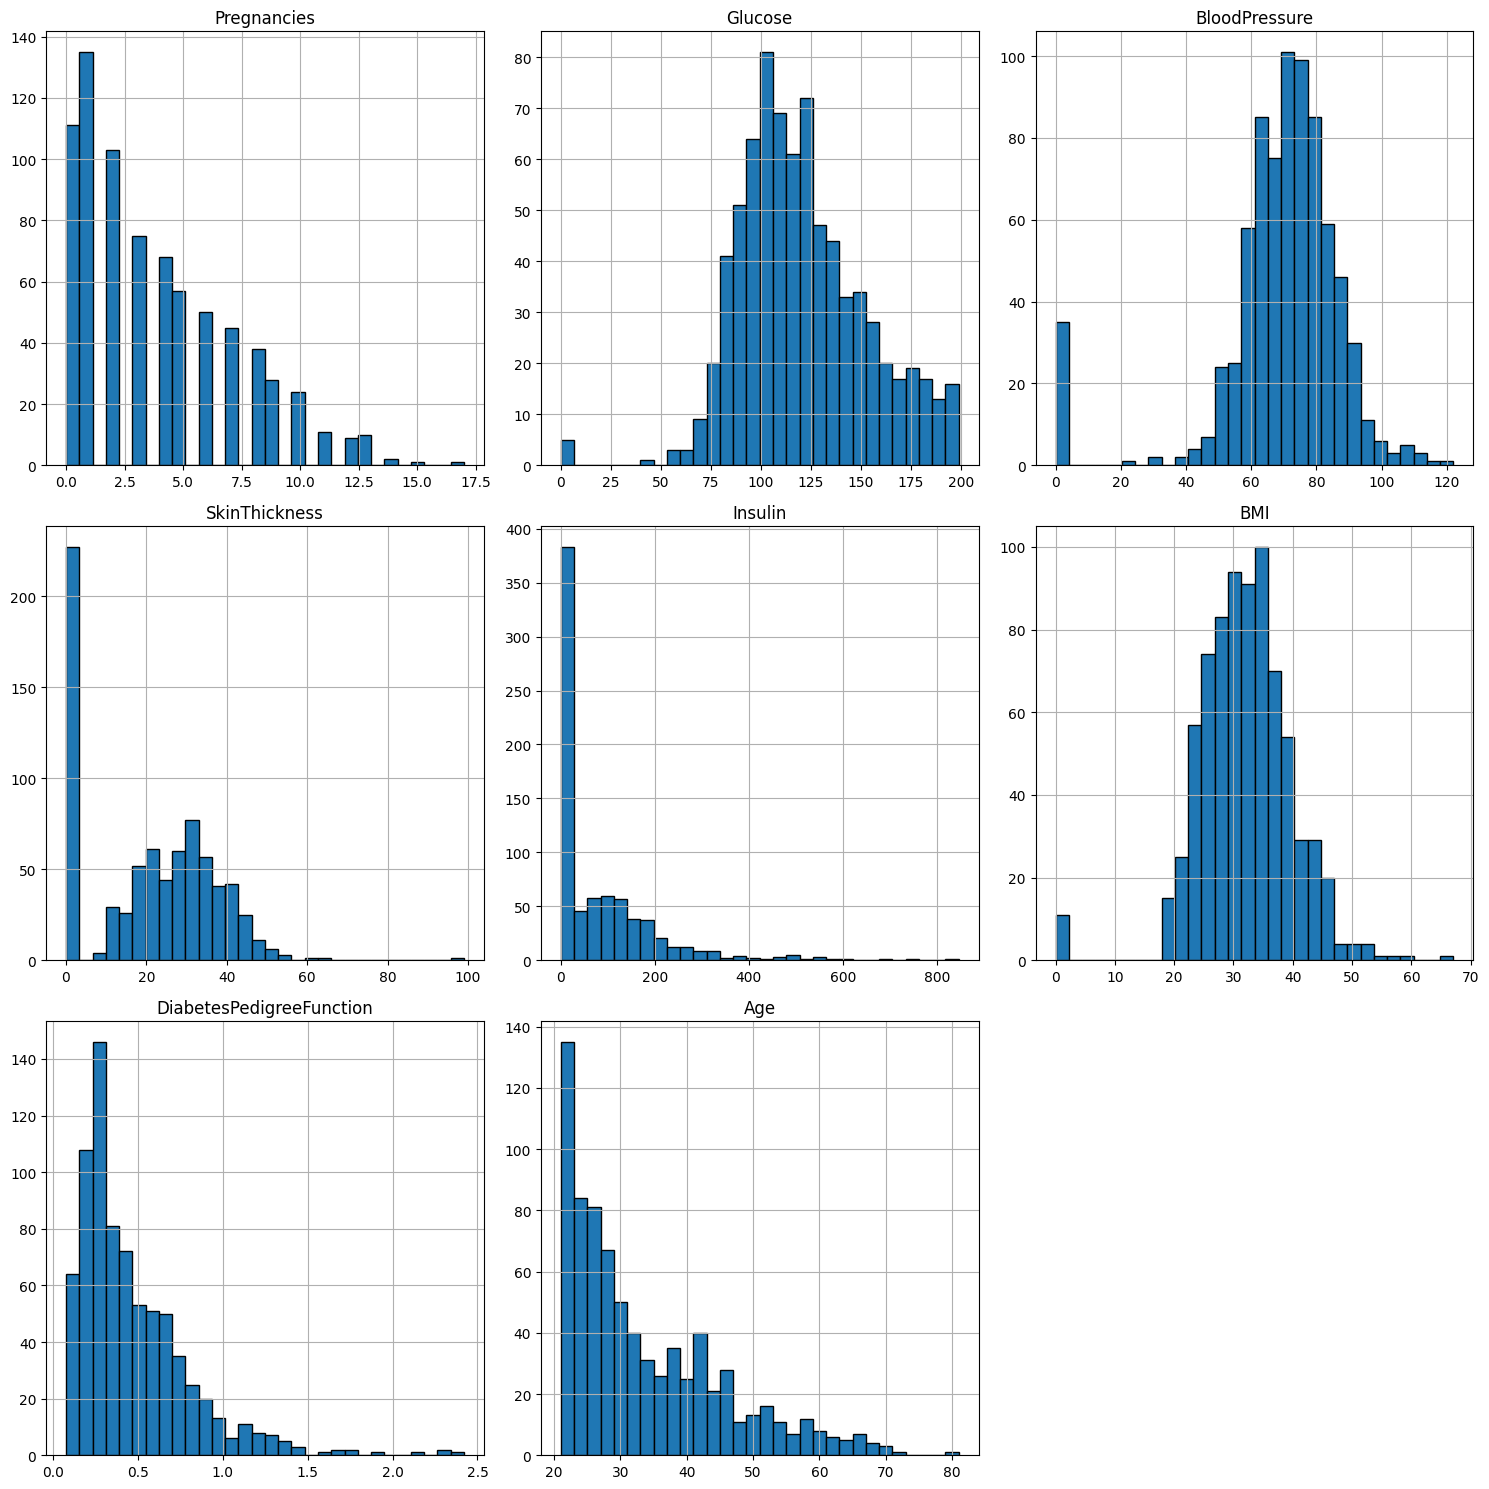

In [7]:
n = len(df.columns)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, feature in enumerate(df.columns):
    df[feature].hist(ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [8]:
print("---- Missing values ---- \n", df.isnull().sum())
print("\n\n---- Zeros ---- \n", (df == 0).sum())

---- Missing values ---- 
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


---- Zeros ---- 
 Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


There are no missing values. However, there are some anomalous values:
- Glucose
- Blood Pressure
- Skin Thickness
- Insulin
- BMI

These values cannot be zero.

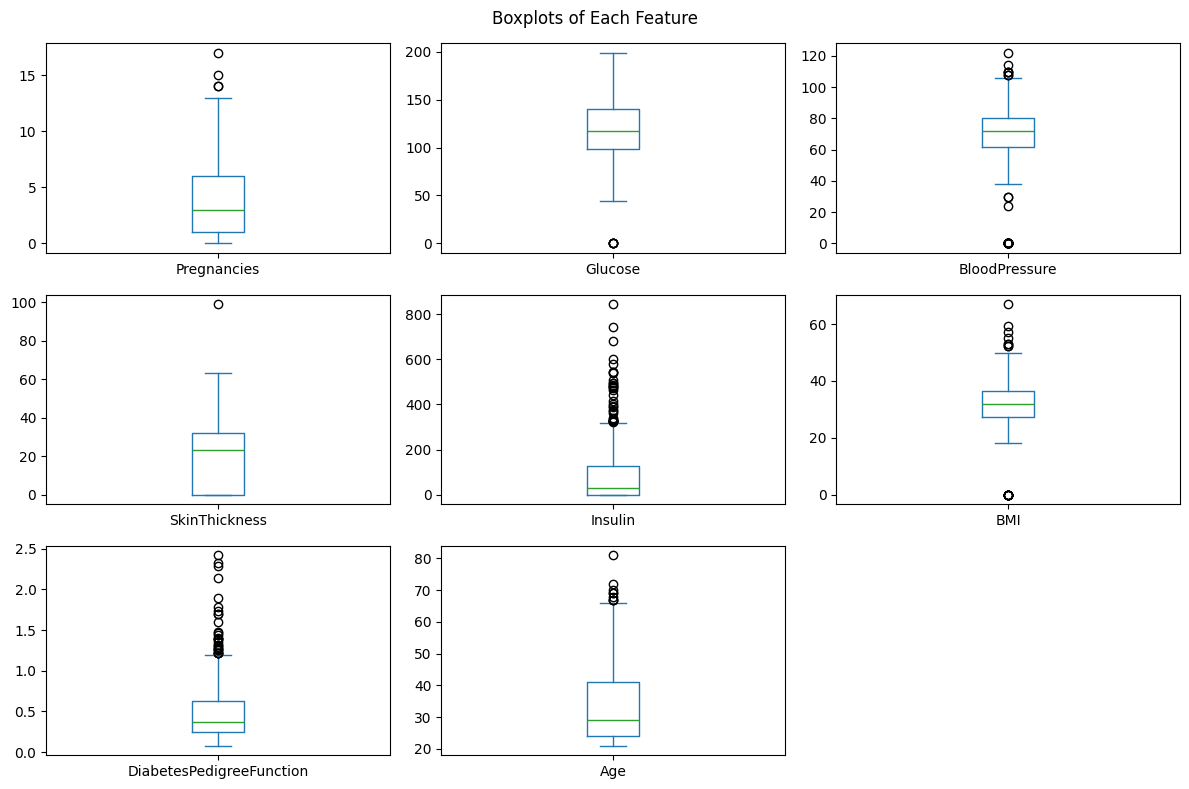

In [9]:
df.plot(kind='box', subplots=True, layout=(3, 3), figsize=(12, 8), sharex=False, sharey=False)
plt.suptitle('Boxplots of Each Feature')
plt.tight_layout()
plt.show()

To avoid data leakage, we only standardize the training set

In [10]:
# We split the dataset
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

numeric_cols = df.select_dtypes(include='number').columns
X_train_numeric = X_train[numeric_cols]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)

X_train_scaled_df

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
60     -0.526397 -1.151398      -3.752683      -1.322774 -0.701206 -4.135256   
618     1.588046 -0.276643       0.680345       0.233505 -0.701206 -0.489169   
346    -0.828460  0.566871      -1.265862      -0.090720  0.013448 -0.424522   
294    -1.130523  1.254179      -1.049617      -1.322774 -0.701206 -1.303720   
231     0.681856  0.410665       0.572222       1.076490  2.484601  1.838121   
..           ...       ...            ...            ...       ...       ...   
71      0.379793  0.566871      -0.292759       0.946800  0.504235 -0.437451   
106    -0.828460 -0.776503       2.842797      -1.322774 -0.701206 -1.239073   
270     1.890109 -0.620297       0.896590       1.076490 -0.701206  1.760544   
435    -1.130523  0.629354      -3.752683      -1.322774 -0.701206  1.346804   
102    -1.130523  0.129493       1.437203      -1.322774 -0.701206 -1.226144   

     DiabetesPedigreeFunction       Age  
60                  -0.490735 -1.035940  
618                  2.415030  1.487101  
346                  0.549161 -0.948939  
294                 -0.639291  2.792122  
231                 -0.686829  1.139095  
..                        ...       ...  
71                  -0.172824 -0.600933  
106                 -0.778934 -0.513932  
270                  1.981245  0.443084  
435                 -0.784877 -0.339929  
102                 -0.615522 -1.035940  

[614 rows x 8 columns]

### Exercise 2 - K-means Clustering

In [11]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled_df)

cluster_labels = kmeans.labels_

# Add the cluster labels to the scaled DataFrame
X_train_scaled_df['cluster'] = cluster_labels

X_train_scaled_df

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
60     -0.526397 -1.151398      -3.752683      -1.322774 -0.701206 -4.135256   
618     1.588046 -0.276643       0.680345       0.233505 -0.701206 -0.489169   
346    -0.828460  0.566871      -1.265862      -0.090720  0.013448 -0.424522   
294    -1.130523  1.254179      -1.049617      -1.322774 -0.701206 -1.303720   
231     0.681856  0.410665       0.572222       1.076490  2.484601  1.838121   
..           ...       ...            ...            ...       ...       ...   
71      0.379793  0.566871      -0.292759       0.946800  0.504235 -0.437451   
106    -0.828460 -0.776503       2.842797      -1.322774 -0.701206 -1.239073   
270     1.890109 -0.620297       0.896590       1.076490 -0.701206  1.760544   
435    -1.130523  0.629354      -3.752683      -1.322774 -0.701206  1.346804   
102    -1.130523  0.129493       1.437203      -1.322774 -0.701206 -1.226144   

     DiabetesPedigreeFunction       Age  cluster  
60                  -0.490735 -1.035940        1  
618                  2.415030  1.487101        0  
346                  0.549161 -0.948939        1  
294                 -0.639291  2.792122        1  
231                 -0.686829  1.139095        0  
..                        ...       ...      ...  
71                  -0.172824 -0.600933        0  
106                 -0.778934 -0.513932        1  
270                  1.981245  0.443084        0  
435                 -0.784877 -0.339929        1  
102                 -0.615522 -1.035940        1  

[614 rows x 9 columns]

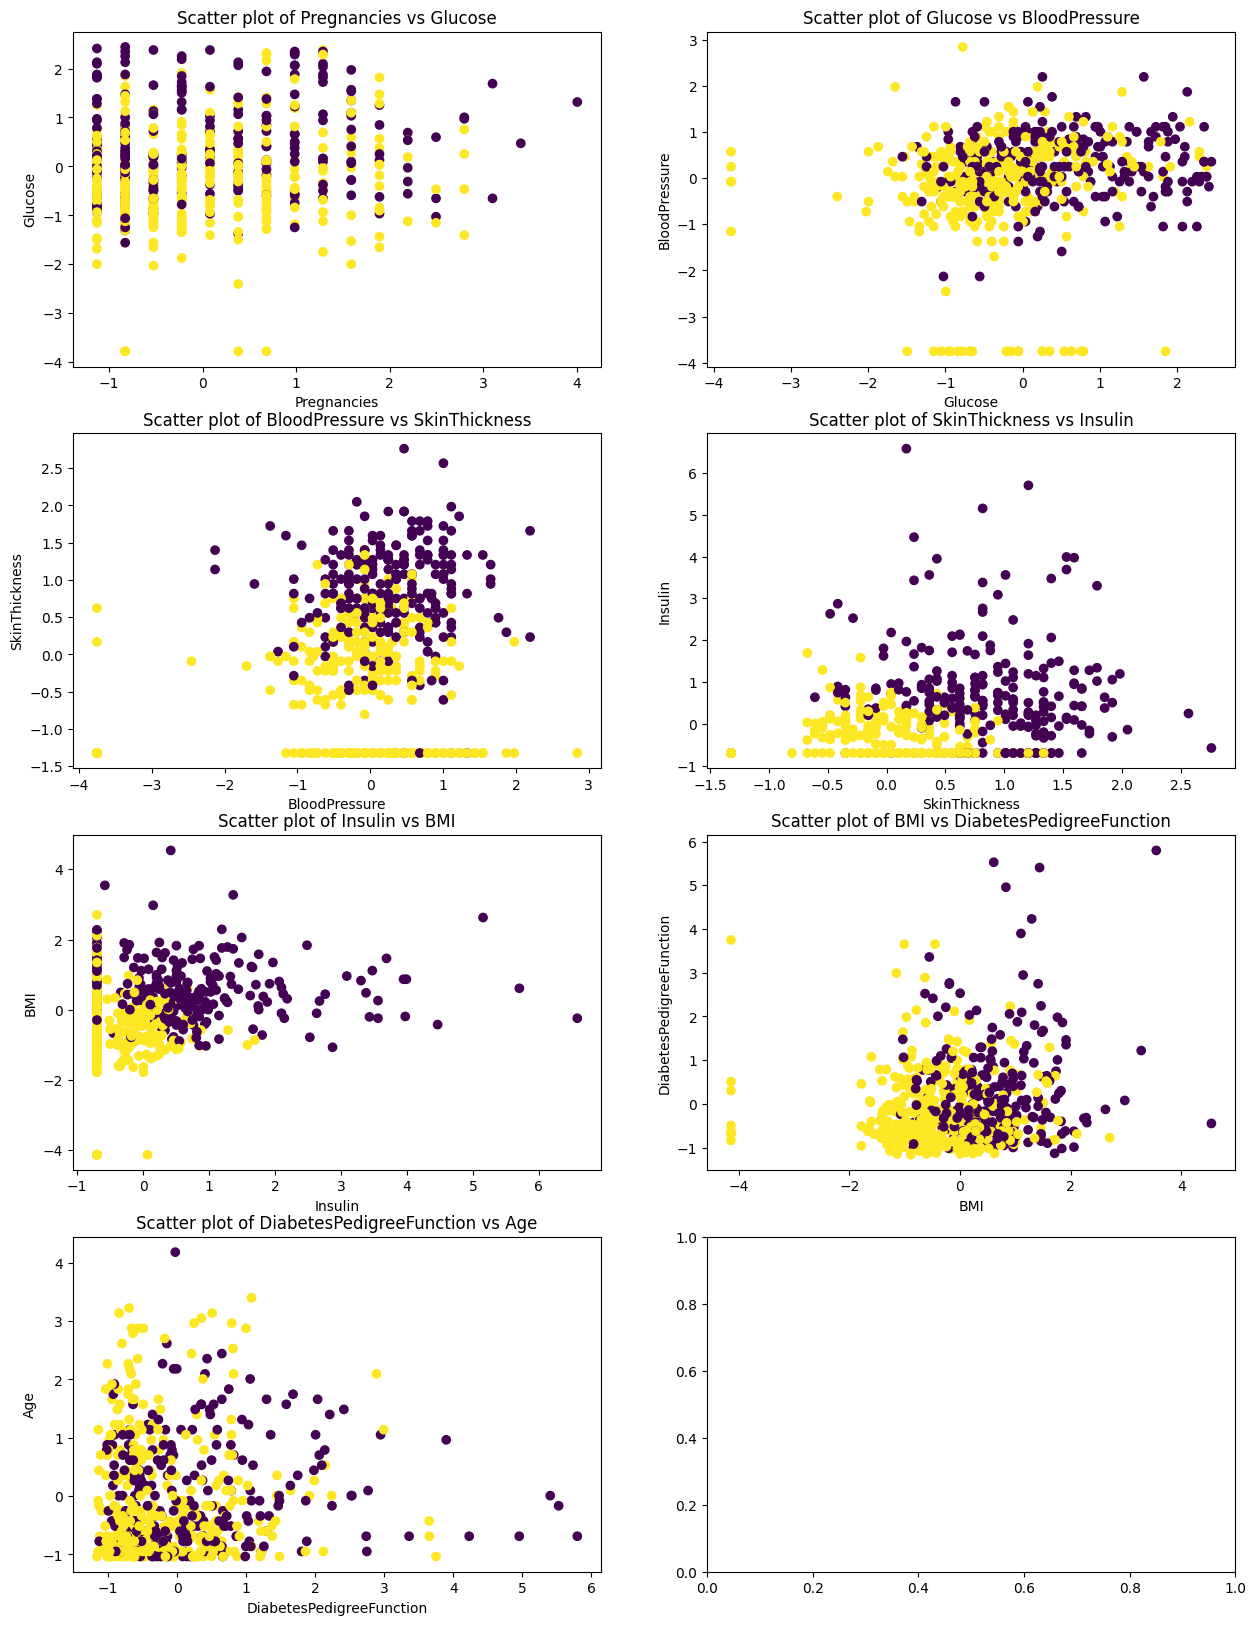

In [12]:
cols = 2
rows = (len(X_train_scaled_df.columns) + cols - 1) // cols - 1
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

for i in range(len(df.columns) - 1):
    axes[i // cols, i % cols].scatter(X_train_scaled_df[df.columns[i]], X_train_scaled_df[df.columns[i+1]], c=X_train_scaled_df['cluster'])
    axes[i // cols, i % cols].set_xlabel(df.columns[i])
    axes[i // cols, i % cols].set_ylabel(df.columns[i+1])
    axes[i // cols, i % cols].set_title(f'Scatter plot of {df.columns[i]} vs {df.columns[i+1]}')

As we can see, the clusters make no sense.
We even can't see delimiter on any plot.
This means that the provided data are not really separable into K groups (here 2). Some datas don't contain useful variance.

### Exercise 3 - PCA and Visualization

In [13]:
X = X_train_scaled_df.drop(columns='cluster', errors='ignore')

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X.index)

X_pca_df

PC1       PC2
60  -4.941712 -0.525098
618  0.915510  1.773579
346 -0.634276 -1.153893
294 -1.103808  2.031867
231  2.900033  0.060172
..        ...       ...
71   0.445656 -0.499450
106 -1.157047  0.512625
270  1.928881  0.706114
435 -1.831314 -0.847250
102 -1.405201 -0.089727

[614 rows x 2 columns]

In [14]:
variance_ratio = pca.explained_variance_ratio_
for i, ratio in enumerate(variance_ratio):
    print(f"PC{i+1}: {ratio:.4f}")

PC1: 0.2553
PC2: 0.2207


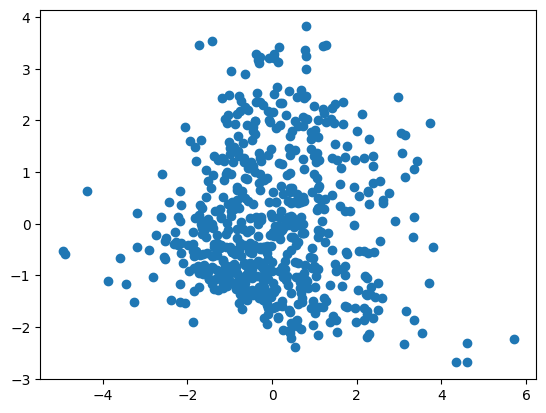

In [15]:
plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'])

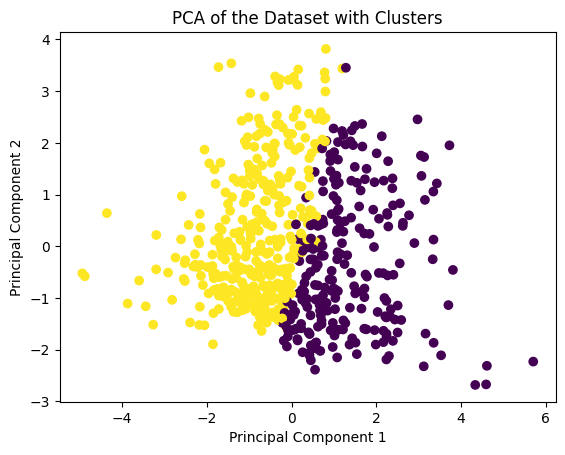

In [16]:
# We add the cluster from the previous kmeans (k=2)
if 'cluster' in X_train_scaled_df.columns:
    X_pca_df['cluster'] = X_train_scaled_df['cluster']

plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], c=X_pca_df['cluster'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of the Dataset with Clusters')
plt.show()

In [17]:
features = X_train_scaled_df.columns[:-1] # Exclude the cluster column

pc_loadings = pd.DataFrame(pca.components_, columns=features, index=['PC1', 'PC2'])

pc_loadings

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
PC1     0.167939  0.403316       0.359404       0.420911  0.441016  0.443144   
PC2     0.568906  0.181750       0.180575      -0.368467 -0.254301 -0.139290   

     DiabetesPedigreeFunction       Age  
PC1                  0.264893  0.204342  
PC2                 -0.114625  0.614596

In [18]:
pc1_top_features = pc_loadings.loc['PC1'].abs().sort_values(ascending=False)
pc2_top_features = pc_loadings.loc['PC2'].abs().sort_values(ascending=False)

print("Top features contributing to PC1:")
print(pc1_top_features.head())

print("\nTop features contributing to PC2:")
print(pc2_top_features.head())

Top features contributing to PC1:
BMI              0.443144
Insulin          0.441016
SkinThickness    0.420911
Glucose          0.403316
BloodPressure    0.359404
Name: PC1, dtype: float64

Top features contributing to PC2:
Age              0.614596
Pregnancies      0.568906
SkinThickness    0.368467
Insulin          0.254301
Glucose          0.181750
Name: PC2, dtype: float64


## Part 2 - Text classification using Bag of Words, TF-IDF, Word2Vec and BERT embeddings 

### Exercise 1: Text Preprocessing

In [63]:
# Load the dataset using scikit-learn's fetch_20newsgroups() method
# And filter the dataset to keep only the records labeled with the computing-related categories:
# 1. comp.graphics
# 2. comp.os.ms-windows.misc
# 3. comp.sys.ibm.pc.hardware
# 4. comp.sys.mac.hardware
# 5. comp.windows.x

dataset2 = fetch_20newsgroups(subset='all', categories=[
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'comp.windows.x'
])

target_names_dataset2 = dataset2.target_names
print(f"Target names: {target_names_dataset2}")

# Create a DataFrame with the text data and labels
df2 = pd.DataFrame({'text': dataset2.data, 'label': dataset2.target})

df2

Target names: ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x']


text  label
0     From: u122743@twncu865.ncu.edu.tw\nSubject: QU...      0
1     From: miket@empros.com (Mike Tipton)\nSubject:...      1
2     From: mark@ocsmd.ocs.com (Mark Wilson)\nSubjec...      0
3     From: kiki@PROBLEM_WITH_INEWS_GATEWAY_FILE (Ke...      0
4     Organization: Queen's University at Kingston\n...      3
...                                                 ...    ...
4886  From: changw@nmt.edu (willie* chang)\nSubject:...      3
4887  From: studner@rintintin.Colorado.EDU (STUDNER ...      2
4888  From: david@pop (David E. Smyth)\nSubject: Re:...      4
4889  From: NURDEN1@elaine.ee.und.ac.za (Dale Nurden...      2
4890  From: jim@n5ial.mythical.com (Jim Graham)\nSub...      2

[4891 rows x 2 columns]

In [47]:
# Preprocess the text:
# o Convert the text to lowercase.
# o Remove punctuation (use regular expressions).
# o Lemmatize the words using spaCy.

nlp = spacy.load("en_core_web_sm")

# Lower case and remove punctuation
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation using regex
    return text
df2["text"] = df2["text"].apply(preprocess_text)

with nlp.select_pipes(disable=["parser", "ner"]):  # We disable the parser and NER components, as we only need tokenization and lemmatization
    preprocessed_texts = []
    for (i, doc) in enumerate(nlp.pipe(df2["text"], batch_size=50, n_process=-1)):
        preprocessed_texts.append(' '.join([token.lemma_ for token in doc]))
    df2["text"] = preprocessed_texts


df2


text  label
0     from u122743twncu865ncuedutw \n subject questi...      0
1     from miketemproscom mike tipton \n subject cha...      1
2     from markocsmdocscom mark wilson \n subject re...      0
3     from kikiproblem_with_inews_gateway_file keith...      0
4     organization queen university at kingston \n f...      3
...                                                 ...    ...
4886  from changwnmtedu willie chang \n subject what...      3
4887  from studnerrintintincoloradoedu studner   rog...      2
4888  from davidpop david e smyth \n subject re r5 t...      4
4889  from nurden1elaineeeundacza dale nurden \n sub...      2
4890  from jimn5ialmythicalcom jim graham \n subject...      2

[4891 rows x 2 columns]

In [48]:
X_train: pd.DataFrame
X_test: pd.DataFrame
y_train: pd.Series
y_test: pd.Series
X_train, X_test, y_train, y_test = train_test_split(df2, df2["label"], test_size=0.2, random_state=42)

In this case, there will be no data leakage between the training and test dataset, because the preprocessing affects each row independently of other rows. 

In [49]:
# We create that dictionary to keep the result into an object (we will use it later)
results = {}

### Exercise 2 - Bag of Words (BoW)

In [50]:
vectorizer = CountVectorizer(stop_words='english') # We pass this parameter to the CountVectorizer to remove stop words

X = vectorizer.fit_transform(X_train['text'])

print(f"Unique words in the vocabulary: {vectorizer.get_feature_names_out()}")

Unique words in the vocabulary: ['00' '000' '0000' ... 'zztvtz8nt2h' 'zzzz' 'ªlt']


In [51]:
LR = LogisticRegression()
LR.fit(X, y_train)

LogisticRegression()

In [ ]:
y_pred = LR.predict(vectorizer.transform(X_test['text']))
accuracy = accuracy_score(y_test, y_pred)
results["CountVectorizer"] = accuracy
print(f"Accuracy: {accuracy:.4f}")

count    979.000000
mean       2.008172
std        1.405487
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: label, dtype: float64
Accuracy: 0.8509


### Exercise 3 - TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X2 = vectorizer.fit_transform(X_train['text'])

X2

<3912x68335 sparse matrix of type '<class 'numpy.float64'>'
	with 326081 stored elements in Compressed Sparse Row format>

In [ ]:
# Sum TF-IDF values for each term across all documents
tfidf_sum = X2.sum(axis=0)
tfidf_sum = np.asarray(tfidf_sum).flatten()

# Get feature names
terms = vectorizer.get_feature_names_out()

# Create DataFrame of terms and their total TF-IDF values
tfidf_df = pd.DataFrame({'term': terms, 'tfidf_sum': tfidf_sum})

tfidf_df.head(10) # Top 10 values

term  tfidf_sum
0              00   2.346860
1             000   0.290990
2            0000   0.119959
3          000000   0.082640
4        00000000   0.140785
5        00000074   0.281570
6          000003   0.155450
7    000005102000   0.026912
8  00000510200001   0.011857
9          00000f   0.155450

In [ ]:
LR2 = LogisticRegression()
LR2.fit(X2, y_train)

LogisticRegression()

In [ ]:
y_pred = LR2.predict(vectorizer.transform(X_test['text']))
accuracy = accuracy_score(y_test, y_pred)
results["TF-IDF"] = accuracy
print(f"Accuracy with TF-IDF: {accuracy:.4f}")

Accuracy with TF-IDF: 0.8703


We notice a better accuracy after using the TF-IDF vectorizer. Indeed, here are the differences between Bag of Words and Term Frequency-Inverse Document Frequency:

Bag of Words:
- It counts how many times each word appears in the text
- It does not implement any feature which gives a weight for a word. Some words with no real meaning such as "the", "and" etc. will all be equally important.

TF-IDF:
- Same features with BoW
- But it implements a feature to know whether a word is common or not.

With these differences, we understand why TF-IDF would be more efficient.

### Exercise 4 - Word2vec

In [ ]:
# Example with one long text column
sentences = X_train['text'].dropna().astype(str).tolist()

tokenized_sentences = [simple_preprocess(sentence) for sentence in sentences]

tokenized_sentences

[['from',
  'eric',
  'bosco',
  'subject',
  'ctrlalt',
  'del',
  'lock',
  'the',
  'computer',
  'fafter',
  'window',
  'replyto',
  'organization',
  'oracle',
  'corp',
  'redwood',
  'shore',
  'can',
  'line',
  'nntppostinghost',
  'xdisclaimer',
  'this',
  'message',
  'be',
  'write',
  'by',
  'an',
  'unauthenticated',
  'user',
  'at',
  'oracle',
  'corporation',
  'the',
  'opinion',
  'express',
  'be',
  'those',
  'of',
  'the',
  'user',
  'and',
  'not',
  'necessarily',
  'those',
  'of',
  'oracle',
  'whenever',
  'exit',
  'window',
  'can',
  'not',
  'use',
  'controlalt',
  'del',
  'to',
  'reboot',
  'my',
  'computer',
  'because',
  'the',
  'system',
  'hang',
  'when',
  'do',
  'this',
  'can',
  'still',
  'reboot',
  'use',
  'the',
  'reset',
  'key',
  'but',
  'would',
  'like',
  'to',
  'know',
  'why',
  'this',
  'happen',
  'eric'],
 ['from',
  'eric',
  'dittman',
  'subject',
  'question',
  'about',
  'irq',
  'and',
  'irq',
  'organiz

In [ ]:
model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,      # dimension of embedding vectors
    window=5,             # context window
    min_count=2,          # ignore words with frequency < 2
    workers=4,            # parallelism
    sg=1                  # 1 = skip-gram; 0 = CBOW
)

model

In [ ]:
def document_vector(doc, model):
    # Filter out words that are not in the Word2Vec vocabulary
    doc = [word for word in doc if word in model.wv]
    
    # If no words are found in the vocab, return a zero vector
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    
    # Average the word vectors
    return np.mean([model.wv[word] for word in doc], axis=0)

# Apply to all documents
document_vectors = np.array([document_vector(doc, model) for doc in tokenized_sentences])

document_vectors

array([[-3.29593979e-02, -6.28289878e-02, -1.39985323e-01, ...,
        -4.50062513e-01,  1.12596877e-01, -1.71389468e-02],
       [ 5.50968526e-03,  2.05539679e-03, -1.25941992e-01, ...,
        -3.42891961e-01,  1.27853766e-01, -1.23692632e-01],
       [-7.08299410e-03,  5.78395603e-03, -1.18127115e-01, ...,
        -3.86378288e-01,  1.16331309e-01, -4.59878966e-02],
       ...,
       [ 1.14740886e-01,  2.25223489e-02, -4.19107761e-04, ...,
        -3.04541886e-01,  2.01717392e-01, -8.31464007e-02],
       [ 4.39491086e-02, -2.37695891e-02, -9.54296514e-02, ...,
        -3.12706232e-01,  1.44960046e-01, -2.68045310e-02],
       [-1.67389698e-02,  3.02579217e-02, -1.33133769e-01, ...,
        -4.03686345e-01,  1.36456415e-01, -6.43227249e-02]], dtype=float32)

In [ ]:
LR3 = LogisticRegression()
LR3.fit(document_vectors, y_train)

/home/avery/machine-learning-efrei-s8/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
sentences_test = X_test['text'].dropna().astype(str).tolist()
tokenized_sentences_test = [simple_preprocess(sentence) for sentence in sentences_test]
document_vectors_test = np.array([document_vector(doc, model) for doc in tokenized_sentences_test])
y_pred = LR3.predict(document_vectors_test)

accuracy = accuracy_score(y_test, y_pred)
results["Word2Vec"] = accuracy
print(f"Accuracy with Word2Vec: {accuracy:.4f}")

Accuracy with Word2Vec: 0.7283


The idea behind Word2Vec is actually to create a dictionary of words. It uses a neural network and outputs a probability distribution to know which word has the nearest meaning according to a context.
The purpose is that words that appear in similar context will might be have the same meaning.

### Exercise 5 - Doc2Vec

In [ ]:
# Vectorize the text using Doc2Vec embeddings.
# Use the Doc2Vec model from Gensim to train word embeddings.

# TaggedDocument format: (words as list, tag)
train_tagged = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(X_train['text'])]

model_d2v = Doc2Vec(min_count=2, workers=1, seed=42)
model_d2v.build_vocab(train_tagged)
model_d2v.train(train_tagged, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

# Get vectors for datasets
def vectorize_docs(model, docs):
    return np.array([model.infer_vector(doc.split()) for doc in docs])

X_train_vec = vectorize_docs(model_d2v, X_train['text'])

X_train_vec


array([[ 0.19197275,  0.03051786,  0.23464702, ...,  0.15361118,
        -0.11207321,  0.20473103],
       [-0.05420151,  0.26824647,  0.13979767, ...,  0.37332076,
         0.06639668, -0.04626814],
       [ 0.50951016, -0.05055641,  0.14887159, ..., -0.00301103,
         0.1704224 ,  0.681143  ],
       ...,
       [-0.01382964,  0.02870401,  0.1550479 , ...,  0.08015028,
        -0.2773403 ,  0.01712946],
       [-0.01158568, -0.00954092,  0.09884819, ...,  0.2876404 ,
        -0.11669873,  0.05701066],
       [-0.05419926, -0.4206582 ,  0.37718898, ...,  0.3969506 ,
        -1.4291373 ,  0.09319172]], dtype=float32)

In [ ]:
# Train a model using Logistic Regression.

clf = LogisticRegression()
clf.fit(X_train_vec, y_train)

LogisticRegression()

In [ ]:
y_pred = clf.predict(vectorize_docs(model_d2v, X_test['text']))
accuracy = accuracy_score(y_test, y_pred)
results["Doc2Vec"] = accuracy
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7140


As the name suggests, Doc2Vec is designed to work with documents rather than just individual words. The algorithm assigns a unique vector to each document and learns to update these vectors during training.
The goal is to learn document embeddings that capture the semantic meaning of the entire document. This allows us to compare documents by measuring the similarity between their vector representations — helping us identify which documents are close in meaning or topic.

### Exercise 6 - BERT Embeddings

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

documents = X_train['text'].dropna().tolist()

def get_bert_embedding(text):
    with torch.no_grad(): # Disable gradient calculation because we are not training the model
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512) # Convert the text into tokens that BERT can understand
        outputs = model(**inputs) # We pass the tokens to the BERT model (created above)
        last_hidden_state = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]

        # Mean pooling
        attention_mask = inputs['attention_mask'] # We previously said that we added a padding. Here we precise that we need to ignore the padding tokens and keep the real tokens
        mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float() # Reshape the attention mask to match the last hidden state (we are going to multiply them)
        masked_embeddings = last_hidden_state * mask # We multiply the last hidden state by the mask to remove the padding tokens
        summed = torch.sum(masked_embeddings, 1) # Sum the embeddings (we will compute the mean of the embeddings)
        counts = torch.clamp(mask.sum(1), min=1e-9) # We need to avoid division by zero
        mean_pooled = summed / counts # Compute the mean of the embeddings
        return mean_pooled.squeeze().numpy()
    
bert_embeddings = [get_bert_embedding(doc) for doc in tqdm(documents)]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
100%|██████████| 3912/3912 [16:50<00:00,  3.87it/s]


In [ ]:
LR4 = LogisticRegression()
LR4.fit(bert_embeddings, y_train)

/home/avery/machine-learning-efrei-s8/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
documents_test = X_test['text'].dropna().tolist()
bert_embeddings_test = [get_bert_embedding(doc) for doc in tqdm(documents_test)]

100%|██████████| 979/979 [04:09<00:00,  3.92it/s]


In [ ]:
y_pred = LR4.predict(bert_embeddings_test)
accuracy = accuracy_score(y_test, y_pred)
results["BERT"] = accuracy
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7058


The meaning behind Bert is that it will create a vector for each word. This means that "blue car" and "red car" will be a different embedding.
We can understand more the context. It's not because there is the same word that the meaning is the same.

### Summary - Comparison of Models and Vectorization Techniques

In [ ]:
# Compare the accuracy of the models : Create a DataFrame with the results and display the table
# Plot the results also as a bar plot
# Answer to the questions: Check out the lab

In [ ]:
pd_result = pd.DataFrame({
    'Vectorization Method': results.keys(),
    'Accuracy': results.values()
})

pd_result

Vectorization Method  Accuracy
0      CountVectorizer  0.850868
1               TF-IDF  0.870276
2             Word2Vec  0.728294
3              Doc2Vec  0.713994
4                 BERT  0.705822

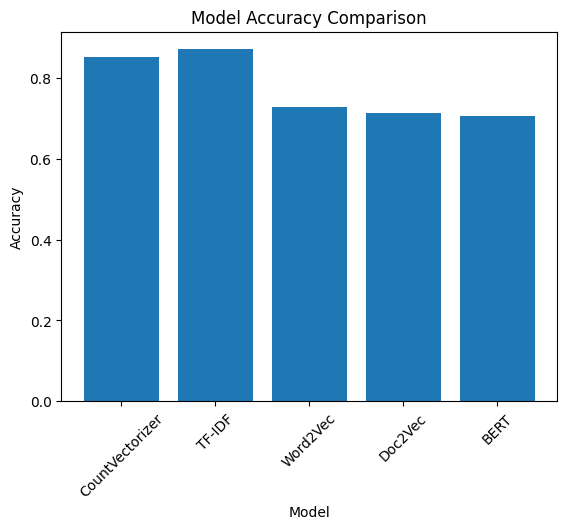

In [ ]:
plt.bar(pd_result['Vectorization Method'], pd_result['Accuracy'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()